# SHL Labs intern hiring Assessment

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**I have implemented many permutations & combinations, I will also be describing that, and the results presented here are of the best parameters achieved**
- Used Whisper, parakeet model for transcription.
- Cleaning of transcription like - removal of disfluencies ("um", "uh", "like", etc.), whitespace and punctuation correction. 
- For creating text embeddings from transcriptions I used bert, distillbert, sentence-transformers & deberta. deberta-V3 achieved the best results
- I also tried incorporating grammatical features like no. of errors, avg_sentence_length, pos_diversity. But by training on these features(+ text embeddings) increased the error score. So discarded these features.

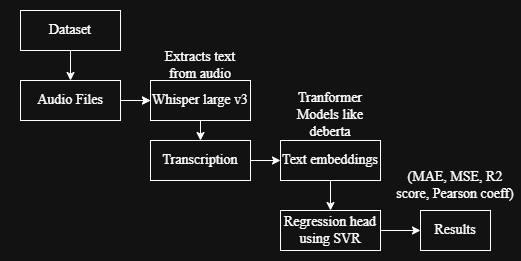
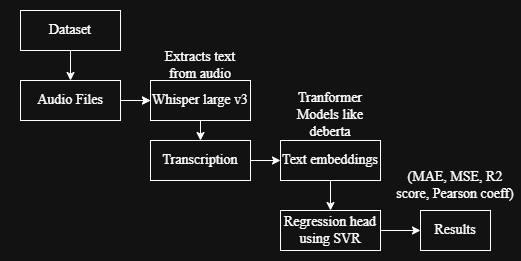

In [2]:
import os
import torch
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoModel, AutoTokenizer

# Config  
WHISPER_MODEL_NAME = "openai/whisper-large-v3"       # Name of the Whisper model to use  
EMBED_MODEL_NAME   = "microsoft/deberta-v3-large"   # Name of the DeBERTa model to use for embeddings  
AUDIO_DIR          = "/kaggle/input/shl-hiring-part-2/dataset/audios/train"  
                                                    # Path to the training audio files directory  
TEST_AUDIO_DIR     = "/kaggle/input/shl-hiring-part-2/dataset/audios/test"  
                                                    # Path to the test audio files directory  
DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"  
                                                    # Set device to GPU if available, else CPU  

## Loading the models

In [3]:
# Load Whisper
whisper_processor = WhisperProcessor.from_pretrained(WHISPER_MODEL_NAME)
whisper_model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME).to(DEVICE)

# Load sentence embedding model
embed_tokenizer = AutoTokenizer.from_pretrained(EMBED_MODEL_NAME)
embed_model = AutoModel.from_pretrained(EMBED_MODEL_NAME).to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [8]:
def transcribe_audio(file_path):
    """
    Transcribes a given audio file into text using the Whisper model.

    Args:
        file_path (str): Path to the input audio file (.wav or similar).

    Returns:
        str: The transcribed text from the audio. Returns an empty string if audio is empty.
    """
    # Load audio at 16kHz (Whisper's expected sampling rate)
    audio, sr = librosa.load(file_path, sr=16000)

    # Ensure audio is float32
    if audio.dtype != np.float32:
        audio = audio.astype(np.float32)

    # Handle empty audio files
    if len(audio) == 0:
        return ""

    # Convert audio to model input features
    inputs = whisper_processor(audio, sampling_rate=16000, return_tensors="pt").to(DEVICE)

    # Get decoder prompt IDs for English transcription
    forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="en", task="transcribe")

    # Generate predicted token IDs without gradient computation
    with torch.no_grad():
        pred_ids = whisper_model.generate(inputs.input_features, forced_decoder_ids=forced_decoder_ids)

    # Decode token IDs to text
    transcription = whisper_processor.batch_decode(pred_ids, skip_special_tokens=True)[0]

    return transcription


In [9]:
def get_text_embedding(text):
    """
    Generates a semantic text embedding using the DeBERTa model.

    Args:
        text (str): Input text string to be embedded.

    Returns:
        np.ndarray: A 1D NumPy array representing the semantic embedding of the input text.
    """
    tokens = embed_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        output = embed_model(**tokens)
        embedding = output.last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

In [10]:
# Step 1: Load training data
train_df = pd.read_csv("/kaggle/input/shl-hiring-part-2/dataset/csvs/train.csv")
print(f"Training samples: {len(train_df)}")

Training samples: 409


In [11]:
train_df.columns

Index(['filename', 'label'], dtype='object')

In [12]:
train_df['label'].value_counts()

label
3.0    154
2.0     90
2.5     72
3.5     46
5.0     20
4.0     15
4.5     10
1.0      1
1.5      1
Name: count, dtype: int64

# Generating the transcriptions and the text embeddings

In [ ]:
# Step 2: Transcribe and embed training samples
X = []
y = []
#transcriptions = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_path = os.path.join(AUDIO_DIR, row['filename'] + ".wav")  # <-- added .wav extension
    try:
        transcription = transcribe_audio(file_path)
        emb = get_text_embedding(transcription)
        X.append(emb)
        y.append(row['label'])
    except Exception as e:
        print(f"Failed to process {row['filename']}: {e}")
    #transcriptions.append(transcription)

#train_df['transcription'] = transcriptions
X = np.array(X)
y = np.array(y)

In [14]:
# Step 3: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [15]:
# These are numpy arrays are not the usual pandas dataframe
print(X_val.shape)
print(X_train.shape)
print(y_val.shape)
print(y_train.shape)

(62, 1024)
(347, 1024)
(62,)
(347,)


# 3D plot for visualization

Embedding matrix shape: (409, 1024)
Label scores shape: (409,)
Label score range: 1.0 to 5.0

Reducing embeddings to 3D using PCA...
PCA explained variance ratio: [0.19229782 0.08326426 0.06994362]
Total variance explained: 0.3455

Reduced embedding shape: (409, 3)

Creating 3D visualization...
✓ 3D plot saved as 'embedding_3d_visualization.png'



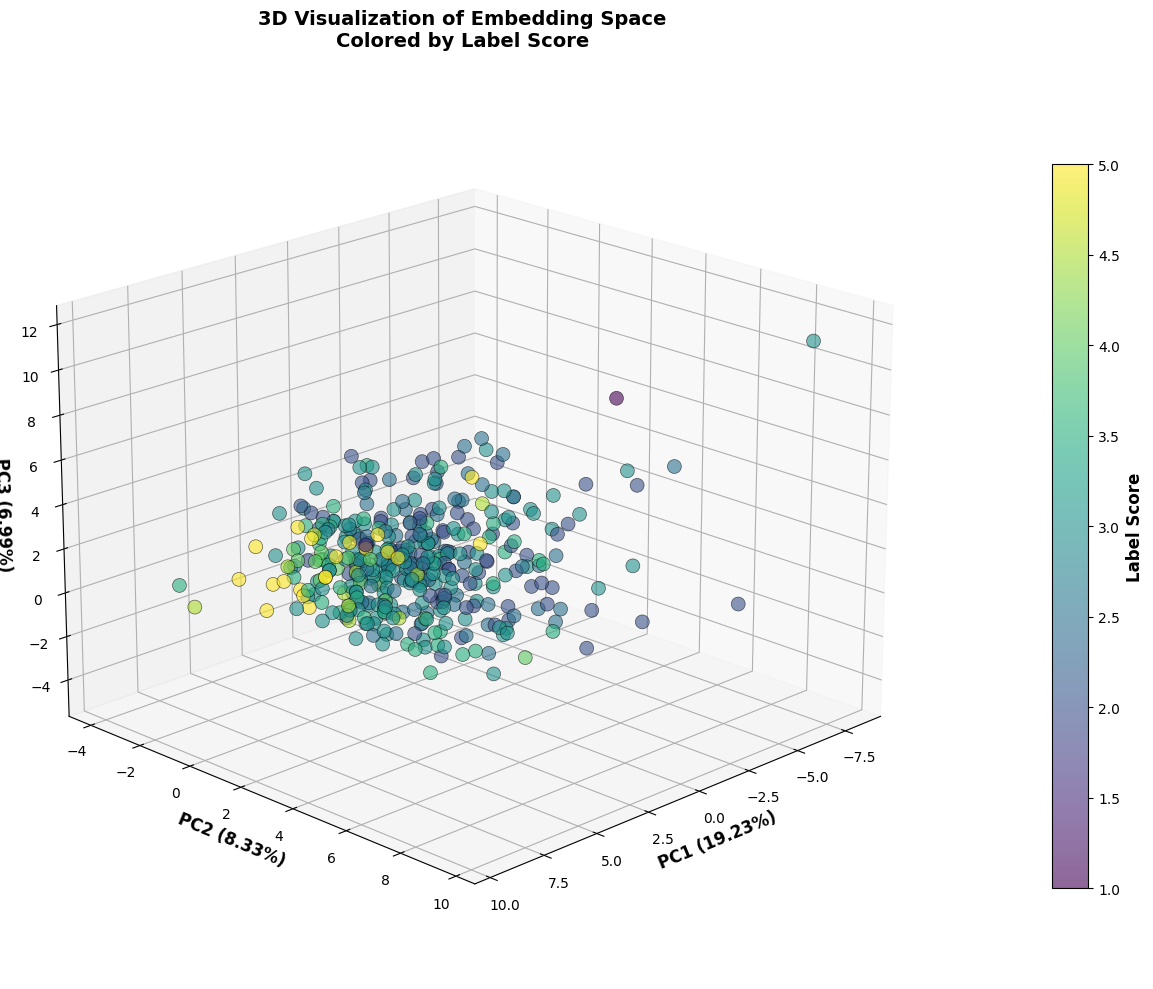

Creating multi-angle visualization...
✓ Multi-angle plot saved as 'embedding_3d_multiangle.png'



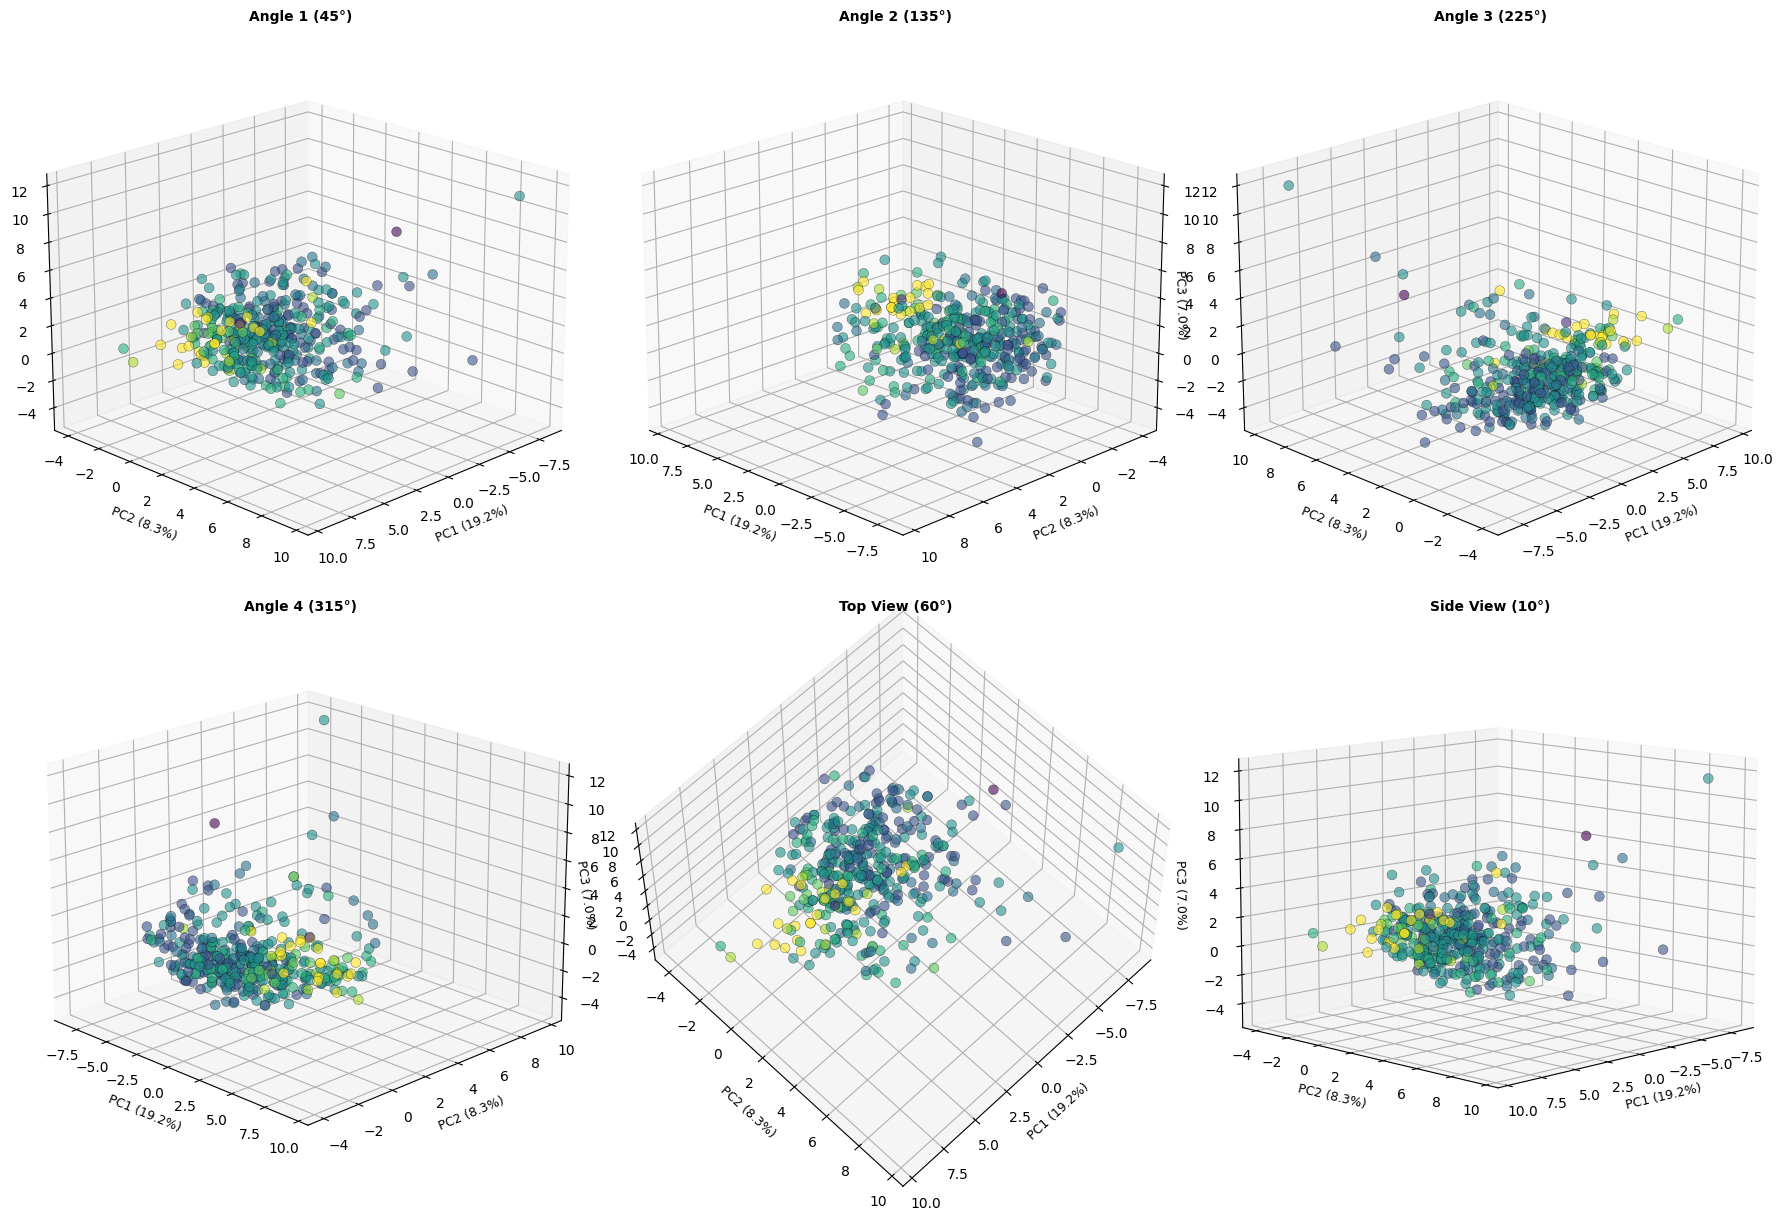

Creating distribution analysis...
✓ Distribution analysis saved as 'embedding_distribution_analysis.png'



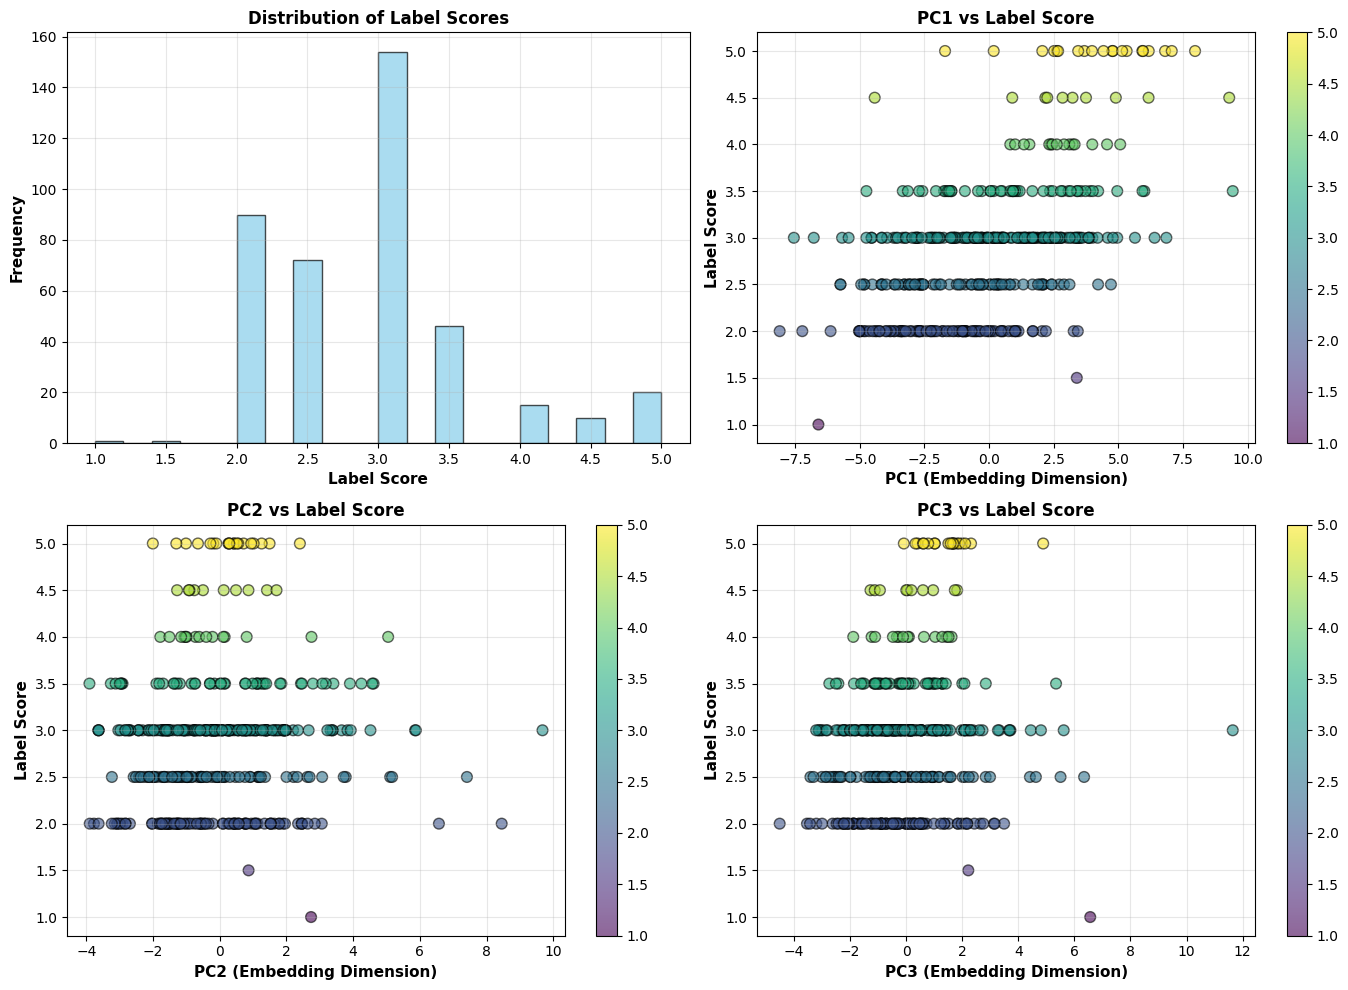

Creating label-grouped 3D visualization...
✓ Grouped 3D plot saved as 'embedding_3d_grouped.png'



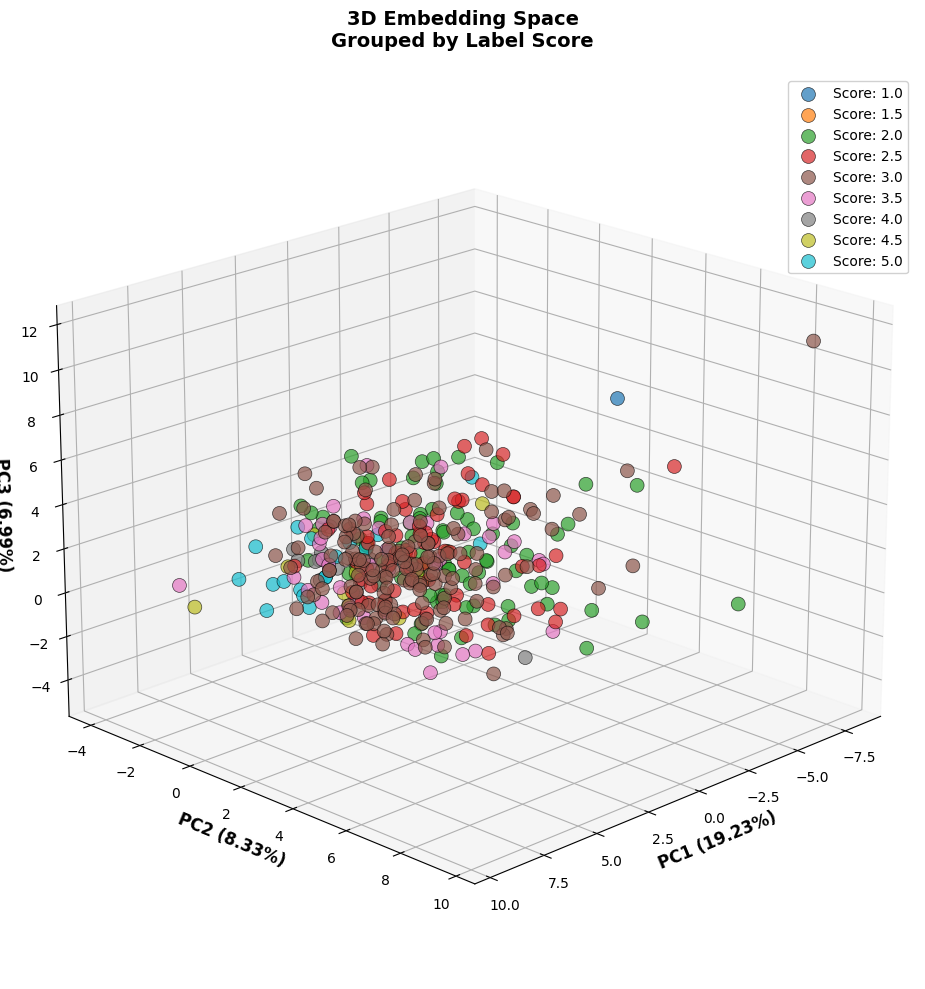

EMBEDDING AND LABEL STATISTICS
Total samples: 409
Embedding dimension (original): 1024
Embedding dimension (PCA): 3

Label Score Statistics:
  Min: 1.0000
  Max: 5.0000
  Mean: 2.9108
  Std: 0.7660
  Median: 3.0000

PCA Explained Variance:
  PC1: 0.1923 (19.23%)
  PC2: 0.0833 (8.33%)
  PC3: 0.0699 (6.99%)
  Total: 0.3455 (34.55%)

PC1 Range: -8.1002 to 9.4221
PC2 Range: -3.9091 to 9.6779
PC3 Range: -4.5051 to 11.6485


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# Assuming you have X (embeddings) and y (labels) from your code
# X shape: (n_samples, 1024) - DeBERTa embeddings
# y shape: (n_samples,) - label scores

print(f"Embedding matrix shape: {X.shape}")
print(f"Label scores shape: {y.shape}")
print(f"Label score range: {y.min()} to {y.max()}\n")

# ==================== PCA REDUCTION ====================
print("Reducing embeddings to 3D using PCA...")
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}\n")
print(f"Reduced embedding shape: {X_pca.shape}\n")

# ==================== 3D SCATTER PLOT ====================
print("Creating 3D visualization...")

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot with color mapping based on label scores
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                     c=y, cmap='viridis', s=100, alpha=0.6, 
                     edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})', fontsize=12, fontweight='bold')

ax.set_title('3D Visualization of Embedding Space\nColored by Label Score', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Label Score', fontsize=12, fontweight='bold')

# Adjust viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('embedding_3d_visualization.png', dpi=300, bbox_inches='tight')
print("✓ 3D plot saved as 'embedding_3d_visualization.png'\n")
plt.show()

# ==================== MULTIPLE VIEWING ANGLES ====================
print("Creating multi-angle visualization...")

fig = plt.figure(figsize=(18, 12))

angles = [(20, 45), (20, 135), (20, 225), (20, 315), (60, 45), (10, 45)]
titles = ['Angle 1 (45°)', 'Angle 2 (135°)', 'Angle 3 (225°)', 
          'Angle 4 (315°)', 'Top View (60°)', 'Side View (10°)']

for idx, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(2, 3, idx+1, projection='3d')
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                         c=y, cmap='viridis', s=50, alpha=0.6, 
                         edgecolors='black', linewidth=0.3)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=9)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=9)
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=9)
    ax.set_title(titles[idx], fontsize=10, fontweight='bold')
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.savefig('embedding_3d_multiangle.png', dpi=300, bbox_inches='tight')
print("✓ Multi-angle plot saved as 'embedding_3d_multiangle.png'\n")
plt.show()

# ==================== DISTRIBUTION ANALYSIS ====================
print("Creating distribution analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Label distribution
ax = axes[0, 0]
ax.hist(y, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Label Score', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Label Scores', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# 2. PC1 vs Label
ax = axes[0, 1]
scatter = ax.scatter(X_pca[:, 0], y, c=y, cmap='viridis', s=60, alpha=0.6, edgecolors='black')
ax.set_xlabel('PC1 (Embedding Dimension)', fontsize=11, fontweight='bold')
ax.set_ylabel('Label Score', fontsize=11, fontweight='bold')
ax.set_title('PC1 vs Label Score', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax)

# 3. PC2 vs Label
ax = axes[1, 0]
scatter = ax.scatter(X_pca[:, 1], y, c=y, cmap='viridis', s=60, alpha=0.6, edgecolors='black')
ax.set_xlabel('PC2 (Embedding Dimension)', fontsize=11, fontweight='bold')
ax.set_ylabel('Label Score', fontsize=11, fontweight='bold')
ax.set_title('PC2 vs Label Score', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax)

# 4. PC3 vs Label
ax = axes[1, 1]
scatter = ax.scatter(X_pca[:, 2], y, c=y, cmap='viridis', s=60, alpha=0.6, edgecolors='black')
ax.set_xlabel('PC3 (Embedding Dimension)', fontsize=11, fontweight='bold')
ax.set_ylabel('Label Score', fontsize=11, fontweight='bold')
ax.set_title('PC3 vs Label Score', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.savefig('embedding_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Distribution analysis saved as 'embedding_distribution_analysis.png'\n")
plt.show()

# ==================== CLUSTERING BY LABEL SCORE ====================
print("Creating label-grouped 3D visualization...")

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique label scores and create distinct colors
unique_labels = sorted(np.unique(y))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = y == label
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], 
              label=f'Score: {label}', s=100, alpha=0.7, 
              color=color, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})', fontsize=12, fontweight='bold')

ax.set_title('3D Embedding Space\nGrouped by Label Score', 
             fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig('embedding_3d_grouped.png', dpi=300, bbox_inches='tight')
print("✓ Grouped 3D plot saved as 'embedding_3d_grouped.png'\n")
plt.show()

# ==================== STATISTICS ====================
print("="*60)
print("EMBEDDING AND LABEL STATISTICS")
print("="*60)
print(f"Total samples: {len(y)}")
print(f"Embedding dimension (original): {X.shape[1]}")
print(f"Embedding dimension (PCA): {X_pca.shape[1]}")
print(f"\nLabel Score Statistics:")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")
print(f"  Median: {np.median(y):.4f}")

print(f"\nPCA Explained Variance:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

print(f"\nPC1 Range: {X_pca[:, 0].min():.4f} to {X_pca[:, 0].max():.4f}")
print(f"PC2 Range: {X_pca[:, 1].min():.4f} to {X_pca[:, 1].max():.4f}")
print(f"PC3 Range: {X_pca[:, 2].min():.4f} to {X_pca[:, 2].max():.4f}")
print("="*60)

```print("\nStep 3: Defining Neural Network...")

class GrammarScoringNet(nn.Module):
    def __init__(self, input_dim=1536, dropout_rate=0.3):
        super(GrammarScoringNet, self).__init__()
        
        # Input layer: 1562 -> 512
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)
        
        # Hidden layer 1: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(dropout_rate)
        
        # Hidden layer 2: 256 -> 128
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(dropout_rate)
        
        # Hidden layer 3: 128 -> 64
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.drop4 = nn.Dropout(dropout_rate)
        
        # Output layer: 64 -> 1 (score prediction)
        self.fc5 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.drop3(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.drop4(x)
        
        x = self.fc5(x)
        return x```

**Note:** I've also trained the regression part using neural network. But it results were very poor from the traditional ML models.
Below is the sample code for it.

In [17]:
# Step 4: Train a regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

regressor = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
regressor.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Step 5: Evaluate on validation
val_preds = regressor.predict(X_val)
train_preds = regressor.predict(X_train)

mse = mean_squared_error(y_train, train_preds)
rmse = mean_squared_error(y_train, train_preds, squared=False)
r2 = r2_score(y_train, train_preds)
pearson_corr, _ = pearsonr(y_train, train_preds)

print("Training Results")
print(f"Training MSE   : {mse:.3f}")
print(f"Training RMSE  : {rmse:.3f}")
print(f"Training R^2   : {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

print("=================================================================================\n")

# Compute evaluation metrics
mse = mean_squared_error(y_val, val_preds)
rmse = mean_squared_error(y_val, val_preds, squared=False)
r2 = r2_score(y_val, val_preds)
pearson_corr, _ = pearsonr(y_val, val_preds)

# Print evaluation
print("Validation Results")
print(f"Validation MSE   : {mse:.3f}")
print(f"Validation RMSE  : {rmse:.3f}")
print(f"Validation R^2   : {r2:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

Training Results
Training MSE   : 0.059
Training RMSE  : 0.242
Training R^2   : 0.906
Pearson Correlation: 0.964

Validation Results
Validation MSE   : 0.214
Validation RMSE  : 0.463
Validation R^2   : 0.429
Pearson Correlation: 0.659


In [19]:
# Step 6: Inference on Test Set
test_df = pd.read_csv("/kaggle/input/shl-hiring-part-2/dataset/csvs/test.csv")
test_preds = []

In [20]:
test_df.columns

Index(['filename'], dtype='object')

# Generating the transcriptions and of test set and final predictions

In [ ]:
#transcriptions = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_path = os.path.join(TEST_AUDIO_DIR, row['filename'] + ".wav")
    
    try:
        transcription = transcribe_audio(file_path)
        emb = get_text_embedding(transcription)
        pred = regressor.predict([emb])[0]
        test_preds.append(pred)
    except Exception as e:
        print(f"Failed to process test file {row['filename']}: {e}")
        test_preds.append(0.0)
    transcriptions.append(transcription)

# Step 7: Save submission
#test_df_2['transcription'] = transcriptions
test_df['label'] = test_preds
test_df.to_csv("predictions_deberta_v3.csv", index=False)
print("Saved predictions to submission.csv")

In [25]:
test_df.shape

(197, 3)

# End of notebook